In [16]:
import librosa
import samplerate
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
from scipy.signal import firwin, filtfilt
import pywt
from scipy.signal import hilbert
from scipy.ndimage import uniform_filter1d

audio_data_path = '原始数据'
txt_file_HCM = '肥厚型梗阻性心肌病.txt'
txt_file_NHCM = '肥厚型非梗阻性心肌病.txt'

with open(txt_file_HCM, 'r') as tf1:
    HCM_files_list = [os.path.join(audio_data_path, name.strip()+'.wav') for name in tf1.readlines()]

with open(txt_file_NHCM, 'r') as tf2:
    NHCM_files_list = [os.path.join(audio_data_path, name.strip()+'.wav') for name in tf2.readlines()]

#测试用文件
test_path = HCM_files_list[40]
if os.path.exists(test_path):
    raw_data, sr = librosa.load(test_path, sr=None)
    #raw_data = raw_data[4*sr:6*sr]
    time = np.array([ i/sr for i in range(len(raw_data))])
    print(time.shape)


##预处理
def FIR_band_pass(data, fs, lowcut, highcut, order, mode='hamming'):
    nums_factor = order+1
    filter = firwin(numtaps=nums_factor, cutoff=[lowcut, highcut], window=mode, pass_zero='bandpass', fs=fs)
    filtered_data = filtfilt(filter, [1], data)
    return filtered_data

def wavelet_denoise(data, wavelet='db6', level=8):
    coeffs = pywt.wavedec(data=data, wavelet=wavelet, level=level)
    sigma = np.median(np.abs(coeffs[3]))/0.6745
    T_thresh = sigma * np.power(2*np.log(len(data)), 0.5)
    denoised_coeffs = [pywt.threshold(c, T_thresh, mode='hard') for c in coeffs]
    denoised_data = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_data[:-1]

def downsample(data, new_fs, sr, mode='sinc_best'):
    down_sample_data = samplerate.resample(data, new_fs/sr, converter_type='sinc_best')
    new_time = np.array([ i/new_fs for i in range(len(down_sample_data))])
    return down_sample_data, new_time 

def normalization(data):
    new_data = data / np.max(np.abs(data))
    return new_data

def envelope_detection_hilbert(data, new_sr):
    analytic_signal = hilbert(data) 
    envelope = np.abs(analytic_signal)  
    smooth_envelope = uniform_filter1d(envelope, size=int(new_sr*0.1))
    return smooth_envelope

def plot_signal(time, data, title, color):
    plt.figure(figsize=(10, 1), dpi=200)
    plt.plot(time, data, linewidth=1, c=color)
    plt.title(title, fontsize=10)
    plt.tick_params(labelsize=10)
    plt.grid()
    plt.show()
    return None

(165375,)


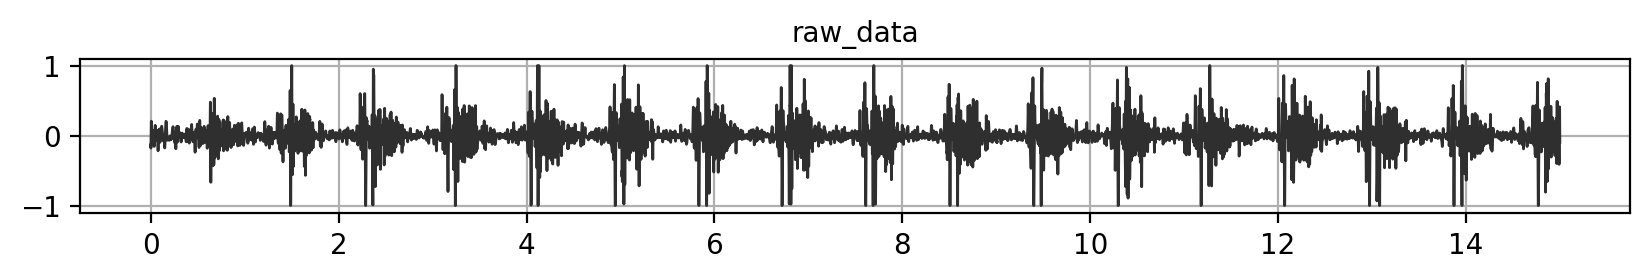

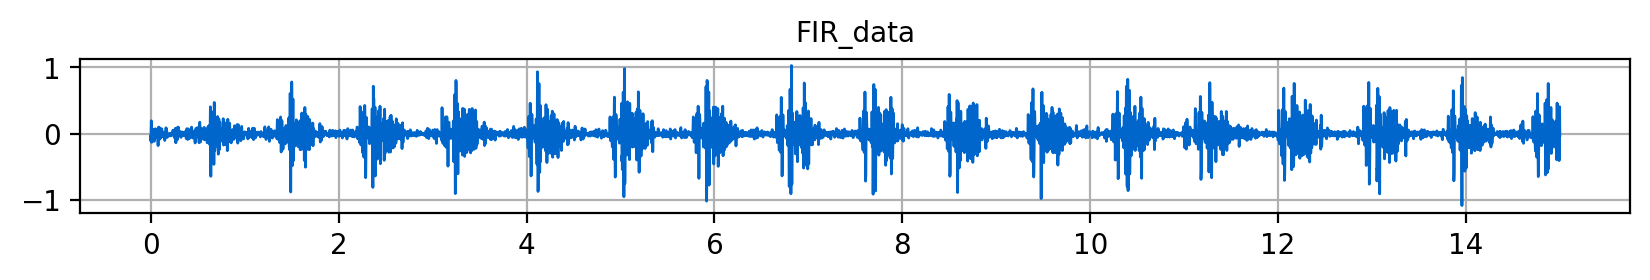

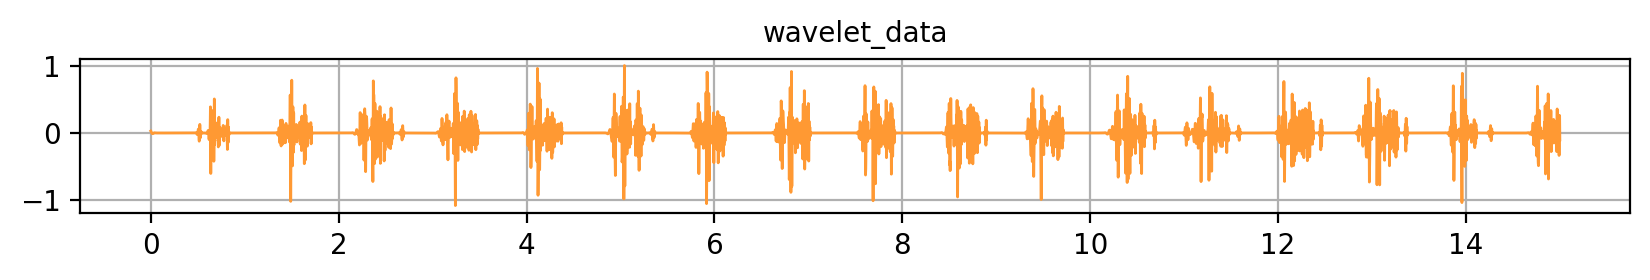

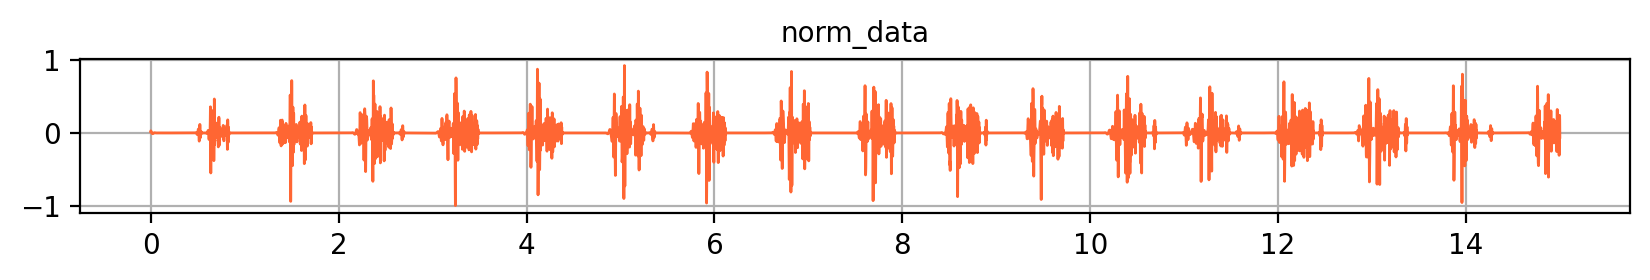

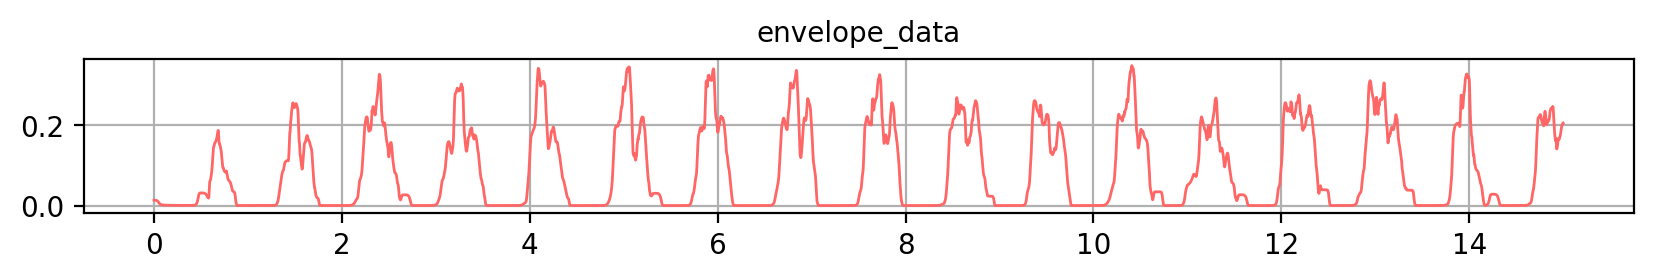

In [18]:
FIR_data = FIR_band_pass(raw_data, sr, 20, 300, 256)
wavelet_data = wavelet_denoise(FIR_data, 'db6', 8)
down_sample_data, new_time= downsample(wavelet_data, 2000, sr)
norm_data = normalization(down_sample_data)
envelope_data = envelope_detection_hilbert(norm_data, 2000)

plot_signal(time, raw_data, 'raw_data', '#2F2F2F')
plot_signal(time, FIR_data, 'FIR_data', '#0066CC')
plot_signal(time, wavelet_data, 'wavelet_data', '#FF9933')
plot_signal(new_time, norm_data, 'norm_data', '#FF6633')
plot_signal(new_time, envelope_data, 'envelope_data', '#FF6666')

In [19]:
def estimate_heart_rate_from_envelope(envelope_data, sr):
    # 假定相隔 300ms 之间才算不同的心音
    min_distance = int(0.3 * sr) 

    peaks, _ = signal.find_peaks(envelope_data, height=np.mean(envelope_data), distance=min_distance)
    
    if len(peaks) < 2:
        return None  

    rr_intervals = np.diff(peaks) / sr 
    avg_rr = np.mean(rr_intervals)  

    heart_rate = 60 / avg_rr
    return heart_rate

heart_rate = estimate_heart_rate_from_envelope(envelope_data, 2000)
print(heart_rate)

67.56281230206207
